In [1]:
%env CUDA_VISIBLE_DEVICES=0

env: CUDA_VISIBLE_DEVICES=0


In [2]:
import numpy as np
import torch
from experiments.heat_diff.network_transformer_vit import EBViTModelWrapper
from torchdyn.core import NeuralODE
from functools import partial
import matplotlib.pyplot as plt

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
model = EBViTModelWrapper(dim=(1, 32, 32),
        num_channels=128,
        num_res_blocks=2,
        channel_mult=[1, 2, 2, 2],
        attention_resolutions="16",
        num_heads=4,
        num_head_channels=64,
        dropout=0.1,
        output_scale=1000.0,
        energy_clamp=None,
        continuous_conditioning=True,
        y_in_features=3,
        # ViT-specific params:
        patch_size=4,
        embed_dim=384,
        transformer_nheads=4,
        transformer_nlayers=8)

state_dict = torch.load("/home/meet/FlowMatchingTests/EnergyMatching/experiments/heat_diff/results/EBMTime_20250724_10/checkpoint_15000.pt")['net_model']
model.load_state_dict(state_dict)
model = model.to(device)
model.eval();

/tmp/ipykernel_2950045/751993295.py:19: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load("/home/meet/FlowMatchingTests/EnergyMatching/experiments/heat_d

In [5]:
cond_model = lambda t, x, args, return_potential=False: model(t, x, y=torch.tensor([0.7, 0.7, 1.]).float().to(device)[None], return_potential=return_potential) \
                                                # +  model(t, x, y=torch.tensor([0.7, 0.3, -1.]).float().to(device)[None], return_potential=return_potential) \
                                                # + model(t, x, y=torch.tensor([0.3, 0.7, -1.]).float().to(device)[None], return_potential=return_potential)

In [6]:
node_ = NeuralODE(cond_model, solver="dopri5", sensitivity="adjoint").to(device)
with torch.no_grad():
    init = torch.randn(15, 1, 32, 32, device=device)
    t_span = torch.linspace(0, 1, 2, device=device)
    traj = node_.trajectory(init, t_span=t_span)
    # traj shape: [num_times, batch_size, 3, 32, 32]
    final = traj[-1]

Your vector field does not have `nn.Parameters` to optimize.


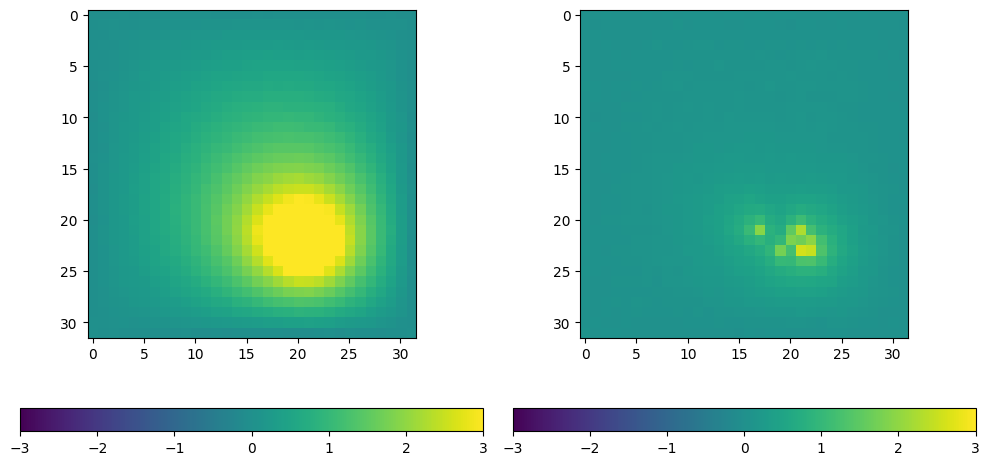

In [27]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(final[ :, 0].mean(dim=0).cpu(), vmax=3, vmin=-3)
a = axes[1].imshow(final[:, 0].std(dim=0).cpu(), vmax=3, vmin=-3)
fig.colorbar(a, orientation='horizontal', ax=axes[0])
fig.colorbar(a, orientation='horizontal', ax=axes[1])
plt.tight_layout()
plt.show()

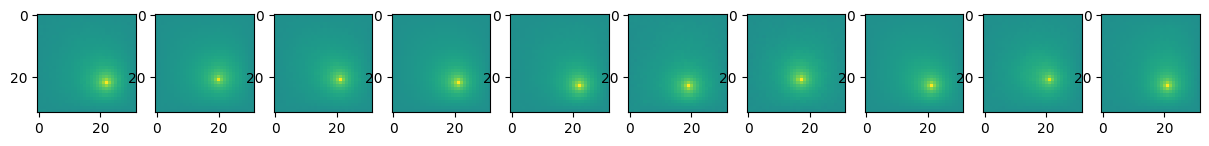

In [8]:
fig, axes = plt.subplots(1, 10, figsize=(15, 5))
for i in range(10):
    axes[i].imshow(final[i,0].cpu().numpy(), vmin=-10, vmax=10)
    # axes[i].set_title(f'Channel {i}')
    # axes[i].axis('off')

In [9]:
cond_model = lambda t, x, return_potential=False: model(t, x, y=torch.tensor([0.7, 0.7, 1.]).float().to(device)[None], return_potential=return_potential) \
                                                +  model(t, x, y=torch.tensor([0.7, 0.3, -1.]).float().to(device)[None], return_potential=return_potential) \
                                                + model(t, x, y=torch.tensor([0.3, 0.7, -1.]).float().to(device)[None], return_potential=return_potential)

def plot_epsilon(t, at_data=False):
    """
    A piecewise function for epsilon(t) in the *plotting* SDE:
      - 0 for t < FLAGS.time_cutoff
      - linearly from 0..epsilon_max as t goes from FLAGS.time_cutoff..1.0
      - constant epsilon_max for t >= 1.0

    If at_data is True, always return epsilon_max (ignore time).
    """
    eps_max = 0.01
    cutoff = 1.0

    # If at_data is True, always return eps_max
    if at_data:
        return eps_max

    if t < cutoff:
        return 0.0
    elif t < 1.0:
        frac = (t - cutoff) / (1.0 - cutoff)  # goes from 0..1
        return frac * eps_max
    else:
        return eps_max

def sde_euler_maruyama(model, x0, t0, t1, dt=0.01, steps_to_save=None):
    """
    Euler–Maruyama integration from t = t0 to t1 with step dt.
    This version does NOT do an extra step if (t1 - t0) is an integer multiple of dt.
    We clamp once at the very end.
    """
    times = torch.arange(t0, t1+1e-6, dt, device=device)

    x = x0.clone().to(device)
    trajectory = []

    for step_idx, t_val in enumerate(times):
        # Optionally store a copy BEFORE the update
        if steps_to_save is None or (step_idx in steps_to_save):
            trajectory.append(x.clone().detach())

        with torch.no_grad():
            v = model(t_val.unsqueeze(0), x)
            # with torch.enable_grad():
            # # 1) Evaluate drift v(t, x)
            #     x.requires_grad_(True)
            #     p = model(t_val.unsqueeze(0), x)
            #     v = - torch.autograd.grad(p.sum(), x)[0]

            # 2) Time-dependent noise scale e(t)
            e = plot_epsilon(float(t_val))
            e_tensor = torch.tensor(e, device=x.device, dtype=x.dtype)
            dt_tensor = torch.tensor(dt, device=x.device, dtype=x.dtype)
            
            # 3) Euler–Maruyama step
            noise = torch.randn_like(x)
            sigma = torch.sqrt(2.0 * e_tensor * dt_tensor)
            x = x + v * dt_tensor + sigma * noise

    # After the final step, clamp once at the very end
    # x = x.clamp(-3, 3)

    # Append final state
    if steps_to_save is None:
        trajectory.append(x.clone().detach())
    else:
        last_step_idx = len(times)  # "one past" the last loop index
        if last_step_idx in steps_to_save:
            trajectory[-1] = x.clone().detach()
        else:
            trajectory.append(x.clone().detach())

    # Return shape: (num_snapshots, batch, channels, height, width)
    return torch.stack(trajectory, dim=0)

In [10]:
dt = 0.01
t_start = 0.0
t_end = 3.0
times = torch.arange(t_start, t_end + 1e-9, dt)
init = torch.randn(10, 1, 32, 32, device=device)

# We'll store frames at t=0,0.1,0.2,...,3.0
sample_every = int(0.1 / dt)
steps_to_save = set(range(0, len(times), sample_every))
steps_to_save.add(len(times) - 1)

traj = sde_euler_maruyama(
    cond_model, init, t0=t_start, t1=t_end, dt=dt, steps_to_save=steps_to_save
)

In [11]:
# 'traj' shape: (num_saved_frames, num_samples, 3, 32, 32).
sorted_steps = sorted(list(steps_to_save))

import matplotlib.pyplot as plt
ncols = len(sorted_steps)
nrows = 10
fig, axes = plt.subplots(
    nrows=nrows, ncols=ncols,
    figsize=(5.0 * ncols, 10.0 * nrows),
    squeeze=False
)

for row_idx in range(nrows):
    for col_idx, step_idx in enumerate(sorted_steps):
        raw_img = traj[col_idx, row_idx]
        # clamped = raw_img.clamp(-1, 1)
        # scaled = (clamped + 1.0) / 2.0

        # Evaluate potential for a quick reference
        t_val = times[step_idx]
        # pot_val = cond_model(
        #     torch.tensor([t_val], device=device),
        #                 raw_img.unsqueeze(0),
        #                 return_potential=True).item()

        np_img = raw_img.cpu().numpy().transpose(1, 2, 0)
        axes[row_idx, col_idx].imshow(np_img, vmax=10, vmin=-10)
        axes[row_idx, col_idx].set_title(f"t={t_val:.1f}", fontsize=60)#, V={pot_val:.3f}")
        axes[row_idx, col_idx].axis("off")

plt.tight_layout()
# plot_path = os.path.join(savedir, f"{net_}_time_evolution_step_{step}.png")
# plt.savefig(plot_path, dpi=100)
# plt.close(fig)
# logging.info(f"Time evolution SDE plot saved to {plot_path}")

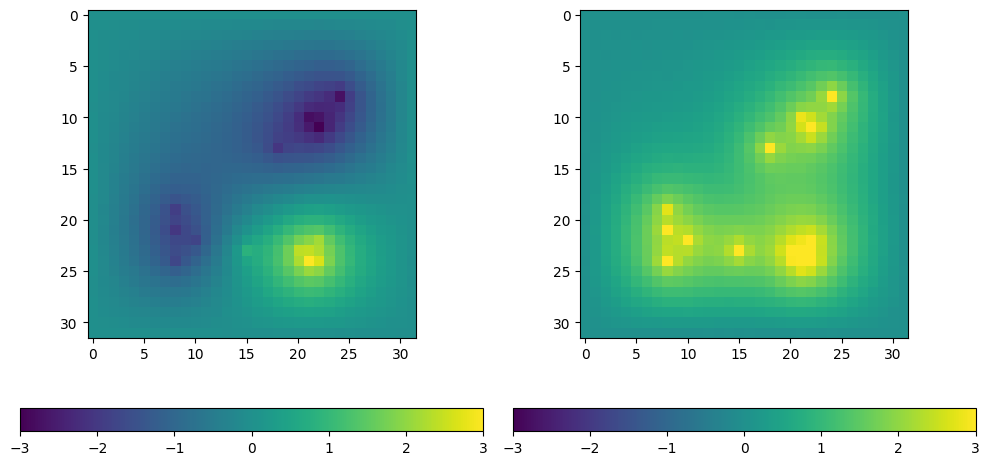

In [26]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(traj[-1, :, 0].mean(dim=0).cpu(), vmax=3, vmin=-3)
a = axes[1].imshow(traj[-1, :, 0].std(dim=0).cpu(), vmax=3, vmin=-3)
fig.colorbar(a, orientation='horizontal', ax=axes[0])
fig.colorbar(a, orientation='horizontal', ax=axes[1])
plt.tight_layout()
plt.show()